In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from math import sqrt
from scipy.stats import norm
from scipy.stats import uniform
import cmath #for complex numbers
from scipy.integrate import quad #for numerical integration
from sklearn.preprocessing import MinMaxScaler
import scipy
import time
import multiprocessing

## Define some Variables

In [ ]:
num_model_parameters = 3
num_strikes = 16
num_maturities = 16


num_input_parameters = 3
num_output_parameters = num_maturities*num_strikes
learning_rate = 0.001
num_steps = 50
batch_size = 10
num_neurons = 40

#initial values
S0 = 1.0
V0 = 0.1
r = 0.05


contract_bounds = np.array([[0.6*S0,1.2*S0],[1,10]]) #bounds for K,T
model_bounds = np.array([[0.01,0.15],[0,1],[-1,0]]) #bounds for alpha,beta,rho, make sure alpha>0, beta,rho \in [0,1]

"""
Note: The grid of stirkes and maturities is equidistant here put could be choosen differently for real world application.
Note: For the code below to striktly follow the bounds specified above make sure that *_distance x num_* is less than half the distance from the highest to lowest * (* = strikes/maturities). 
"""
maturities_distance = (contract_bounds[1,1]-contract_bounds[1,0])/(2*num_maturities) 
strikes_distance = (contract_bounds[0,1]-contract_bounds[0,0])/(2*num_strikes)

strikes = np.linspace(contract_bounds[0,0],contract_bounds[0,0]+num_strikes*strikes_distance,num_strikes)
maturities = np.linspace(contract_bounds[1,0],contract_bounds[1,0]+num_maturities*maturities_distance,num_maturities)

In [ ]:
X = tf.placeholder(tf.float32, [None, num_input_parameters])
y = tf.placeholder(tf.float32, [None, num_output_parameters])

## Some Helper Functions

In [ ]:
def corr_brownian_motion(n, T, dim, rho):
    dt = T/n

    dW1 = norm.rvs(size=(dim,n+1) , scale=sqrt(dt))
    dW2 = rho * dW1 + np.sqrt(1 - np.power(rho ,2)) * norm.rvs(size=(dim,n+1) , scale=sqrt(dt))
        
    W1 = np.cumsum(dW1, axis=-1)
    W2 = np.cumsum(dW2, axis=-1)
 
    return W1,W2

def euler_maruyama(mu,sigma,T,x0,W):
    dim = W.shape[0]
    n = W.shape[1]-1
    Y = np.zeros((dim,n+1))
    dt = T/n
    sqrt_dt = np.sqrt(dt)
    for l in range(dim):
        Y[l,0] = x0
        for i in range(n):
            Y[l,i+1] = Y[l,i] + np.multiply(mu(Y[l,i],l,i),dt) + sigma(Y[l,i],l,i)*sqrt_dt*(W[l,i+1]-W[l,i])
    
    return Y

def sabr(alpha,beta,T,W,Z,V0,S0):
    #print(beta)
    #assert(beta>0 and beta<1)

    def mu2(V,i,k):
        return 0.0
    
    def sigma2(V,i,k):
        return np.multiply(alpha,V)
    
    V = euler_maruyama(mu2,sigma2,T,V0,Z)
    
    def mu1(S,i,k):
        return 0.0
    
    def sigma1(S,i,k):
        return np.multiply(V[i,k],np.power(np.maximum(0.0,S),beta))
    
    S = euler_maruyama(mu1,sigma1,T,S0,W)
    
    return S,V

def reverse_transform_X(X_scaled):
    X = np.zeros(X_scaled.shape)
    for i in range(num_input_parameters):
        X[:,i] = X_scaled[:,i]*(model_bounds[i][1]-model_bounds[i][0]) + model_bounds[i][0]
    return X

def price_pred(alpha,beta,rho,n,dim,T,K,V0,S0):
    W,Z = corr_brownian_motion(n,T,dim,rho)
    S,V = sabr(alpha,beta,T,W,Z,V0,S0)
    S_T = S[:,n]
    P = np.exp(-r*T) * np.mean(np.maximum(S_T-K,np.zeros(dim)))
    
    return P

def next_batch_sabr_EM_train(batch_size,contract_bounds,model_bounds):
    X_scaled = np.zeros((batch_size,num_input_parameters))
    y = np.zeros((batch_size,num_output_parameters))

    X_scaled[:,0] = uniform.rvs(size=batch_size) #alpha
    X_scaled[:,1] = uniform.rvs(size=batch_size) #beta
    X_scaled[:,2] = uniform.rvs(size=batch_size) #rho

    X = reverse_transform_X(X_scaled)

    n = 100
    dim = 50
    for i in range(batch_size):
        for j in range(num_maturities):
            for k in range(num_strikes):
                y[i,j*num_strikes+k] = price_pred(X[i,0],X[i,1],X[i,2],n,dim,maturities[j],strikes[k],V0,S0)

    return X_scaled,y

## Design of the NN

In [ ]:
#Layers
hidden1 = fully_connected(X, num_neurons, activation_fn=tf.nn.elu)
bn1 = tf.nn.batch_normalization(hidden1, 0, 1, 0, 1, 0.000001)
hidden2 = fully_connected(bn1, num_neurons, activation_fn=tf.nn.elu)
bn2 = tf.nn.batch_normalization(hidden2, 0, 1, 0, 1, 0.000001)
hidden3 = fully_connected(bn2, num_neurons, activation_fn=tf.nn.elu)
bn3 = tf.nn.batch_normalization(hidden3, 0, 1, 0, 1, 0.000001)
hidden4 = fully_connected(hidden3, num_neurons, activation_fn=tf.nn.elu)
bn4 = tf.nn.batch_normalization(hidden4, 0, 1, 0, 1, 0.000001)

outputs = fully_connected(bn4, num_output_parameters, activation_fn=None)

In [ ]:
#Loss Function
loss = tf.reduce_mean(tf.sqrt(tf.square(outputs - y)))  # MSE

#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [ ]:
num_cpu = multiprocessing.cpu_count()
config = tf.ConfigProto(device_count={ "CPU": num_cpu },
                                        inter_op_parallelism_threads=num_cpu,
                                        intra_op_parallelism_threads=2,
                                        )

with tf.Session(config=config) as sess:
    sess.run(init)
    
    for iteration in range(num_steps):
        
        X_batch,Y_batch = next_batch_sabr_EM_train(batch_size,contract_bounds,model_bounds)
        sess.run(train,feed_dict={X: X_batch, y: Y_batch})
        
        if iteration % 1 == 0:
            
            rmse = loss.eval(feed_dict={X: X_batch, y: Y_batch})
            print(iteration, "\tRMSE:", rmse)
    
    saver.save(sess, "./models/sabr_dnn")

## More Helper Functions
### Note: You can choose which trained weights to use below

In [7]:
def prices_grid(theta):
    prices_true = np.zeros((1,num_output_parameters))
    n = 100
    dim = 200
    for i in range(num_maturities):
        for j in range(num_strikes):        
            prices_true[0,i*num_strikes+j] = price_pred(theta_true[0],theta_true[1],theta_true[2],n,dim,maturities[i],strikes[j],V0,S0)
    return prices_true

In [8]:
def predict_theta(prices_ture):   
    
    def NNprediction(theta):
        x = np.zeros((1,len(theta)))
        x[0,:] = theta
        return sess.run(outputs,feed_dict={X: x})
    def NNgradientpred(x):
        x = np.asarray(x)
        grad = np.zeros((num_output_parameters,num_input_parameters))
        
        delta = 0.000001
        for i in range(num_input_parameters):
            h = np.zeros(x.shape)
            h[0,i] = delta
            
            #two point gradient
            #grad[i] = (sess.run(outputs,feed_dict={X: x+h}) - sess.run(outputs,feed_dict={X: x-h}))/2/delta

            #four point gradient
            grad[:,i] = (-sess.run(outputs,feed_dict={X: x+2*h})+8*sess.run(outputs,feed_dict={X: x+h})-8*sess.run(outputs,feed_dict={X: x-h}) +sess.run(outputs,feed_dict={X: x-2*h}))/12/delta

        return np.mean(grad,axis=0)

    def CostFuncLS(theta):
        
        return np.sqrt(np.mean(np.power((NNprediction(theta)-prices_true.flatten())[0],2),axis=0))


    def JacobianLS(theta):
        x = np.zeros((1,len(theta)))
        x[0,:] = theta
        return NNgradientpred(x).T

    with tf.Session() as sess:                          
        #saver.restore(sess, "./models/sabr_dnn")  
        saver.restore(sess, "./models/sabr_dnn_e")    
        
        init = [model_bounds[0,0]+uniform.rvs()*(model_bounds[0,1]-model_bounds[0,0]),model_bounds[1,0]+uniform.rvs()*(model_bounds[1,1]-model_bounds[1,0]),model_bounds[2,0]+uniform.rvs()*(model_bounds[2,1]-model_bounds[2,0])]
        bnds = ([model_bounds[0,0],model_bounds[1,0],model_bounds[2,0]],[model_bounds[0,1],model_bounds[1,1],model_bounds[2,1]])


        I=scipy.optimize.least_squares(CostFuncLS,init,JacobianLS,bounds=bnds,gtol=1E-15,xtol=1E-15,verbose=1)

    theta_pred = I.x
    
    return theta_pred

## Predict and Plot for one specific theta_true

In [9]:
theta_true = [0.1,0.5,-0.5]
prices_true = prices_grid(theta_true)

In [10]:
theta_pred = predict_theta(prices_true)

INFO:tensorflow:Restoring parameters from ./models/sabr_dnn_e
`xtol` termination condition is satisfied.
Function evaluations 27, initial cost 8.4811e-04, final cost 8.4811e-04, first-order optimality 5.53e-04.


In [11]:
print(theta_true)
print(theta_pred)

[0.1, 0.5, -0.5]
[ 0.09568445  0.41372336 -0.69722396]


In [12]:
prices_true = np.zeros((num_maturities,num_strikes))
prices_pred = np.zeros((num_maturities,num_strikes))
init = [model_bounds[0,0]+uniform.rvs()*(model_bounds[0,1]-model_bounds[0,0]),model_bounds[1,0]+uniform.rvs()*(model_bounds[1,1]-model_bounds[1,0]),model_bounds[2,0]+uniform.rvs()*(model_bounds[2,1]-model_bounds[2,0])]
prices_trash = np.zeros((num_maturities,num_strikes))
n = 100
dim = 300
for i in range(num_maturities):
    for j in range(num_strikes):        
        prices_true[i,j] = price_pred(theta_true[0],theta_true[1],theta_true[2],n,dim,maturities[i],strikes[j],V0,S0)
        prices_pred[i,j] = price_pred(theta_pred[0],theta_pred[1],theta_pred[2],n,dim,maturities[i],strikes[j],V0,S0)
        prices_trash[i,j] = price_pred(init[0],init[1],init[2],n,dim,maturities[i],strikes[j],V0,S0)

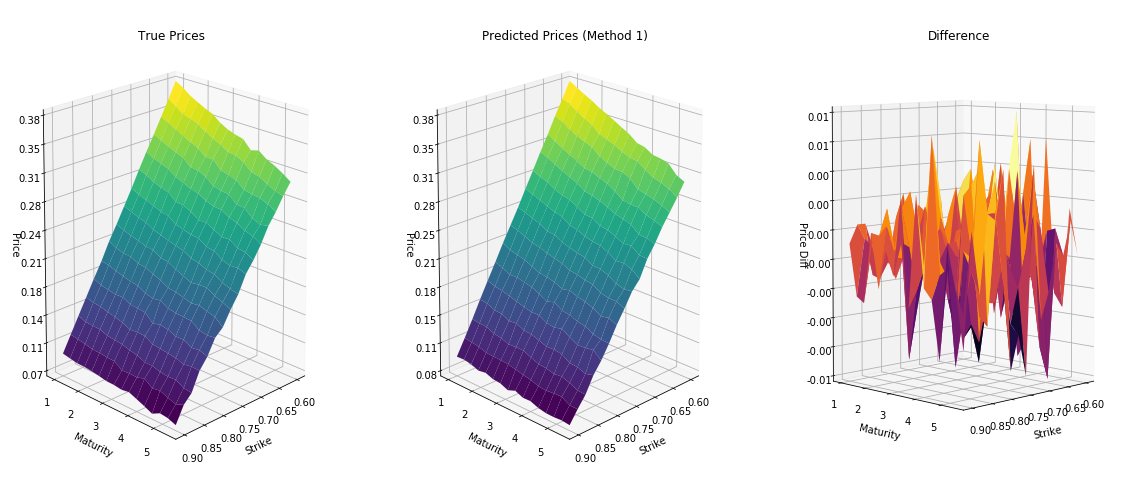

In [13]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fig = plt.figure(figsize=(20, 9))

T_ = np.zeros((num_maturities,num_strikes))
K_ = np.zeros((num_maturities,num_strikes))
for i in range(num_strikes):
    for j in range(num_maturities):
        T_[j,i] = maturities[j]
for j in range(num_maturities):   
    for i in range(num_strikes):
        K_[j,i] = strikes[i]

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X=K_, Y=T_, Z=prices_true, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax1.zaxis.set_major_locator(LinearLocator(10))
ax1.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax1.set_xlabel('Strike')
ax1.set_ylabel('Maturity')
ax1.set_zlabel('Price')
ax1.set_title('True Prices')
ax1.view_init(15, 45)

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X=K_, Y=T_, Z=prices_pred, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax2.zaxis.set_major_locator(LinearLocator(10))
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax2.set_xlabel('Strike')
ax2.set_ylabel('Maturity')
ax2.set_zlabel('Price')
ax2.set_title('Predicted Prices (Method 1)')
ax2.view_init(15, 45)


ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X=K_, Y=T_, Z=prices_true-prices_pred, rstride=1, cstride=1, cmap='inferno', edgecolor='none')
ax3.zaxis.set_major_locator(LinearLocator(10))
ax3.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax3.set_xlabel('Strike')
ax3.set_ylabel('Maturity')
ax3.set_zlabel('Price Diff')
ax3.set_title('Difference')
ax3.view_init(5, 45)
"""
ax3 = fig.add_subplot(133)
ax3.imshow(prices_true-prices_pred,cmap='Blues_r')
ax3.set_xticks(np.linspace(0,num_strikes-1,num_strikes))
ax3.set_xticklabels(np.around(strikes,decimals=1))
ax3.set_yticks(np.linspace(0,num_maturities-1,num_maturities))
ax3.set_yticklabels(np.around(maturities,decimals=1))
"""
plt.savefig('prices_dnn.pdf') 
plt.show()


In [ ]:
mean_err = np.mean(np.mean(np.abs(prices_true-prices_pred),axis=0),axis=0)
mean_err_init = np.mean(np.mean(np.abs(prices_true-prices_trash),axis=0),axis=0)
mean_true_price = np.mean(np.mean(np.abs(prices_true),axis=0),axis=0)
print("MSE: ",mean_err)
print("MSE Init: ",mean_err_init)
print("Percent of avg True Price: ",mean_err/mean_true_price)

### Create Grid of Model Parameters and corresponding Prices

In [15]:
bb = 2
num_thetas = np.power(bb,num_model_parameters)
thetas_true = np.zeros((num_thetas,num_model_parameters))

for i in range(bb):
    for j in range(bb):
        for k in range(bb):
            thetas_true[i*bb*bb+j*bb+k,0] = model_bounds[0,0]+ k *(model_bounds[0,1]-model_bounds[0,0])/(bb-1)
            thetas_true[i*bb*bb+j*bb+k,1] = model_bounds[1,0]+ j *(model_bounds[1,1]-model_bounds[1,0])/(bb-1)
            thetas_true[i*bb*bb+j*bb+k,2] = model_bounds[2,0]+ i *(model_bounds[2,1]-model_bounds[2,0])/(bb-1)


In [16]:
thetas_pred = np.zeros((num_thetas,num_model_parameters))
for i in range(num_thetas):
    thetas_pred[i,:] = predict_theta(prices_grid(thetas_true[i,:]).flatten())

INFO:tensorflow:Restoring parameters from ./models/sabr_dnn_e
`xtol` termination condition is satisfied.
Function evaluations 28, initial cost 4.4859e-04, final cost 4.4859e-04, first-order optimality 5.07e-04.
INFO:tensorflow:Restoring parameters from ./models/sabr_dnn_e
`xtol` termination condition is satisfied.
Function evaluations 28, initial cost 1.6792e-03, final cost 1.6792e-03, first-order optimality 3.56e-04.
INFO:tensorflow:Restoring parameters from ./models/sabr_dnn_e
`xtol` termination condition is satisfied.
Function evaluations 30, initial cost 2.6058e-04, final cost 2.6058e-04, first-order optimality 5.09e-04.
INFO:tensorflow:Restoring parameters from ./models/sabr_dnn_e
`xtol` termination condition is satisfied.
Function evaluations 28, initial cost 1.9647e-04, final cost 1.9647e-04, first-order optimality 3.64e-04.
INFO:tensorflow:Restoring parameters from ./models/sabr_dnn_e
`xtol` termination condition is satisfied.
Function evaluations 27, initial cost 1.9199e-04, f

In [17]:
diff = np.mean(np.mean(np.power(thetas_pred - thetas_true,2),axis=0),axis=0)
print(thetas_true)
print(np.around(thetas_pred,5))

[[ 0.01  0.   -1.  ]
 [ 0.15  0.   -1.  ]
 [ 0.01  1.   -1.  ]
 [ 0.15  1.   -1.  ]
 [ 0.01  0.    0.  ]
 [ 0.15  0.    0.  ]
 [ 0.01  1.    0.  ]
 [ 0.15  1.    0.  ]]
[[ 0.14433  0.77062 -0.63425]
 [ 0.0723   0.06641 -0.8252 ]
 [ 0.04298  0.00939 -0.0684 ]
 [ 0.10402  0.2507  -0.17312]
 [ 0.05864  0.8128  -0.3416 ]
 [ 0.0337   0.70163 -0.11746]
 [ 0.04887  0.04579 -0.65   ]
 [ 0.0386   0.14574 -0.41773]]


In [18]:
rel_error = np.mean(np.abs(thetas_pred - thetas_true),axis=1)/np.abs(np.mean(thetas_true,axis=1))
print("Relative Error: ",  rel_error )

Relative Error:  [  1.28353397   0.3751864  195.51916667  10.81438838 120.30426021
   6.23592291   1.62681658   1.20294475]


In [19]:
prices_grid_true = np.zeros((num_thetas,num_maturities,num_strikes))
prices_grid_pred = np.zeros((num_thetas,num_maturities,num_strikes))
n = 100
dim = 100
for i in range(num_thetas):
    for j in range(num_maturities):
        for k in range(num_strikes):
            prices_grid_true[i,j,k] = price_pred(thetas_true[i,0],thetas_true[i,1],thetas_true[i,2],n,dim,maturities[i],strikes[j],V0,S0)
            prices_grid_pred[i,j,k] = price_pred(thetas_pred[i,0],thetas_pred[i,1],thetas_pred[i,2],n,dim,maturities[i],strikes[j],V0,S0)

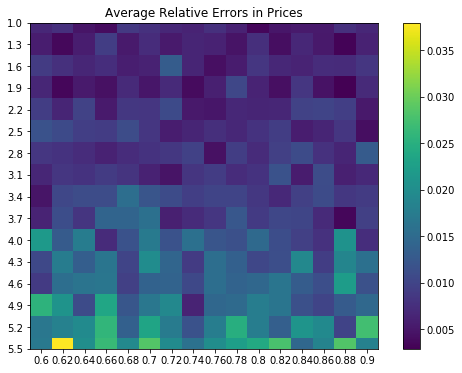

In [29]:
fig = plt.figure(figsize=(9, 6))

ax=plt.subplot(1,1,1)

plt.imshow(np.mean(np.abs((prices_grid_true-prices_grid_pred)/prices_grid_true),axis=0))
plt.title("Average Relative Errors in Prices")

ax.set_yticks(np.linspace(0,num_maturities-1,num_maturities))
ax.set_yticklabels(np.around(maturities,1))
ax.set_xticks(np.linspace(0,num_strikes-1,num_strikes))
ax.set_xticklabels(np.around(strikes,2))


plt.colorbar()

plt.show()

In [54]:
N = 10

thetas_true_rand = reverse_transform_X(uniform.rvs(size=(N,num_model_parameters)))

In [55]:
thetas_pred_rand = np.zeros((N,num_model_parameters))
for i in range(N):
    thetas_pred_rand[i,:] = predict_theta(prices_grid(thetas_true_rand[i,:]).flatten())

INFO:tensorflow:Restoring parameters from ./models/sabr_dnn_e


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key beta1_power_1 not found in checkpoint
	 [[node save_1/RestoreV2 (defined at /Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]

Original stack trace for 'save_1/RestoreV2':
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
    yield self.process_one()
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 714, in __init__
    self.run()
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-43-a14e4d1bb035>", line 10, in <module>
    saver = tf.train.Saver()
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 828, in __init__
    self.build()
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 840, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 878, in _build
    build_restore=build_restore)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 508, in _build_internal
    restore_sequentially, reshape)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 328, in _AddRestoreOps
    restore_sequentially)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/training/saver.py", line 575, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_io_ops.py", line 1696, in restore_v2
    name=name)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "/Users/robinvogtland/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
rel_error_rand = np.mean(np.abs(thetas_pred_rand - thetas_true_rand),axis=1)/np.abs(np.mean(thetas_true_rand,axis=1))
print("Relative Error: ",  rel_error_rand )

In [ ]:
prices_grid_true_2 = np.zeros((num_thetas,num_maturities,num_strikes))
prices_grid_pred_2 = np.zeros((num_thetas,num_maturities,num_strikes))
n = 100
dim = 100
for i in range(N):
    for j in range(num_maturities):
        for k in range(num_strikes):
            prices_grid_true_2[i,j,k] = price_pred(thetas_true_rand[i,0],thetas_true_rand[i,1],thetas_true_rand[i,2],n,dim,maturities[i],strikes[j],V0,S0)
            prices_grid_pred_2[i,j,k] = price_pred(thetas_pred_rand[i,0],thetas_pred_rand[i,1],thetas_pred_rand[i,2],n,dim,maturities[i],strikes[j],V0,S0)

In [ ]:
fig = plt.figure(figsize=(18, 6))

ax1=fig.add_subplot(121)

plt.imshow(np.mean(np.abs((prices_grid_true-prices_grid_pred)/prices_grid_true),axis=0))
plt.title("Average Relative Errors in Prices")

ax1.set_yticks(np.linspace(0,num_maturities-1,num_maturities))
ax1.set_yticklabels(np.around(maturities,1))
ax1.set_xticks(np.linspace(0,num_strikes-1,num_strikes))
ax1.set_xticklabels(np.around(strikes,2))
plt.colorbar()
ax2=fig.add_subplot(122)

plt.imshow(np.max(np.abs((prices_grid_true-prices_grid_pred)/prices_grid_true),axis=0))
plt.title("Max Relative Errors in Prices")

ax2.set_yticks(np.linspace(0,num_maturities-1,num_maturities))
ax2.set_yticklabels(np.around(maturities,1))
ax2.set_xticks(np.linspace(0,num_strikes-1,num_strikes))
ax2.set_xticklabels(np.around(strikes,2))


plt.colorbar()
plt.savefig('errors_dnn_m1_e.pdf') 
plt.show()
